In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import my_utils as myf
import matplotlib.path as mpath
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from matplotlib.gridspec import GridSpec

In [2]:
mydir = './data/fram_export/'

In [3]:
myfiles = [f for f in sorted(os.listdir(mydir))]
listds = []
for file in myfiles: 
        ds = xr.open_dataset(mydir+file)
        ds = ds.set_coords('names')
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [4]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')
ds = xr.concat([ds,lensmean],dim='names')

In [5]:
lineplotprop = myf.set_line_prop(ds.names.values)

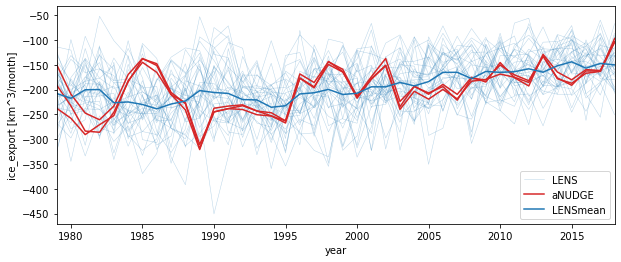

In [6]:
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
for n, name in enumerate(ds.names.values):
            ds.sel(names=name).groupby('time.year').mean(dim='time').ice_export.plot(ax = ax, **lineplotprop[name].to_dict())     
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlim([1979,2018])
ax.set_title('')
plt.show()
plt.close()

In [7]:
mydir = './data/sia_sie_siv_timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'nh' in f]
listds = []
for f in myfiles:
    if 'OB' not in f:
        sids = xr.open_dataset(f)[['sie_nh']]
        sids = sids.set_coords('names')
        myname = str(sids.names.values)
        if 'LENS' in myname:
                sids['names'] = 'LENS'+myname[-2:]
        listds.append(sids)
sids = xr.concat(listds,dim='names')

thelens = [f for f in sids.names.values if 'LENS' in f]
lensmean = sids.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')
sids = xr.concat([sids,lensmean],dim='names')

In [8]:
sie_nh = myf.xr_reshape(sids.sie_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
trend_sie, intercept_sie, r_value_sie, p_value_sie, std_err_sie = myf.linregress(sie_nh.year, sie_nh.load(), dim='year')

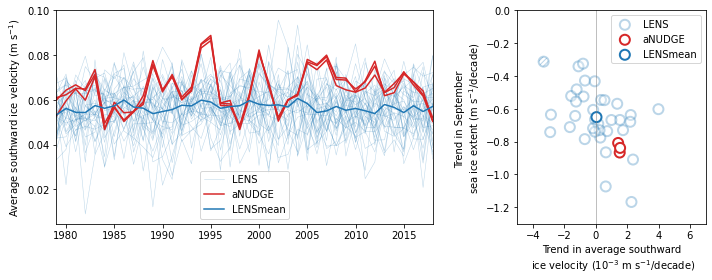

In [9]:
mydata = ds.groupby('time.year').mean(dim='time').avg_north_vel
trend, intercept, r_value, p_value, std_err = myf.linregress(mydata.year, -mydata.load(), dim='year')

fig = plt.figure(figsize=(10,4))
gs = GridSpec(1, 2, width_ratios=[1, .5])

ax = fig.add_subplot(gs[0])
for n, name in enumerate(ds.names.values):
        (-1*ds.sel(names=name).groupby('time.year').mean(dim='time').avg_north_vel).plot(ax = ax, **lineplotprop[name].to_dict())     

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlim([1979,2018])
ax.set_title('')
ax.set_ylabel('Average southward ice velocity (m s$^{-1}$)')
ax.set_xlabel('')


ax = fig.add_subplot(gs[1])
ax.axvline(x=0.,c='grey',linewidth=0.5)

for n, name in enumerate(ds.names.values):
    mk = ''
    if p_value.sel(names=name)<0.05:      
        mk= '/////'
    
    ax.scatter(10.*trend.sel(names=name)*1e3, 10.*trend_sie.sel(names=name).sel(month=9),s=100.,
               facecolor = 'white', edgecolors=lineplotprop[name]['c'],alpha=lineplotprop[name]['alpha'],hatch=mk,linewidth=2, label = lineplotprop[name]['label'])
          

ax.set_xlabel('Trend in average southward\n ice velocity (10$^{-3}$ m s$^{-1}$/decade)')
ax.set_ylabel('Trend in September \nsea ice extent (m s$^{-1}$/decade)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlim([-5,7])
ax.set_ylim([-1.3,0])

plt.tight_layout()
plt.subplots_adjust(wspace=.3)
fig.savefig('figs/fram_vel.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()